In [1]:
# Dependencies
# Analysis
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# ML
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler

---
# Data Loading and EDA

In [2]:
# Establish connection to sqlite db
cnx = sqlite3.connect('Resources/bank_churners.db')
customer_churn_df = pd.read_sql_query('SELECT * FROM bank_churners', cnx)

In [3]:
# Check column names
customer_churn_df.columns

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')

In [4]:
# Check datatypes
customer_churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

In [5]:
# Check for missing values
customer_churn_df.isnull().sum()

CLIENTNUM                                                                                                                             0
Attrition_Flag                                                                                                                        0
Customer_Age                                                                                                                          0
Gender                                                                                                                                0
Dependent_count                                                                                                                       0
Education_Level                                                                                                                       0
Marital_Status                                                                                                                        0
Income_Category                                 

In [6]:
# Drop unnecessary columns
customer_churn_df = customer_churn_df.drop(columns= ['CLIENTNUM', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'])
customer_churn_df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,F,3,High School,Married,Less than $40K,Blue,36,4,3,3,3544.0,1661,1883.0,0.831,15149,111,0.734,0.469
1,Attrited Customer,58,M,0,Unknown,Single,$40K - $60K,Blue,45,3,1,3,3421.0,2517,904.0,0.992,992,21,0.400,0.736
2,Attrited Customer,46,M,3,Doctorate,Divorced,$80K - $120K,Blue,38,6,3,3,8258.0,1771,6487.0,0.000,1447,23,0.000,0.214
3,Existing Customer,34,F,2,Uneducated,Single,Less than $40K,Blue,24,6,2,2,1438.3,0,1438.3,0.827,3940,82,0.952,0.000
4,Existing Customer,49,F,2,Uneducated,Married,Unknown,Blue,41,3,5,2,3128.0,749,2379.0,0.598,4369,59,0.735,0.239


In [7]:
# Review the shape of the df
df_row_count = customer_churn_df.shape[0]
customer_churn_df.shape

(10127, 20)

In [8]:
# Descriptive statistics
customer_churn_df.describe()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


In [9]:
# Check for class imbalance
print(customer_churn_df['Attrition_Flag'].value_counts())


Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64


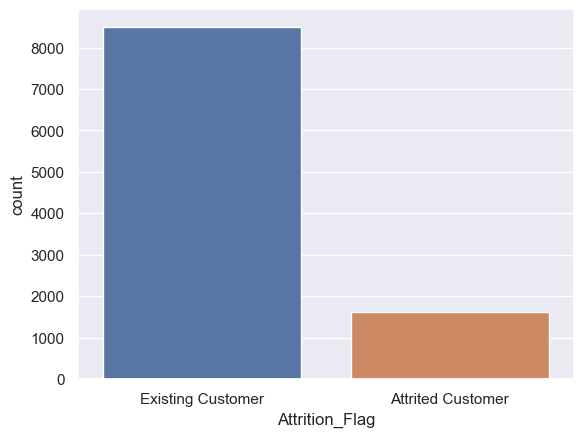

In [10]:
# Bar plot to visualize existing and attrited customers
attrition_df = customer_churn_df['Attrition_Flag'].value_counts().reset_index()
attrition_df = attrition_df.rename(columns= {'index': 'Attrition_Flag', 'Attrition_Flag': 'count'})

# Set plot style
sns.set(style="darkgrid")

sns.barplot(x= 'Attrition_Flag',
            y= 'count',
            data= attrition_df)

# Save figure
plt.savefig('Figures/attrition_bar.png', bbox_inches='tight')

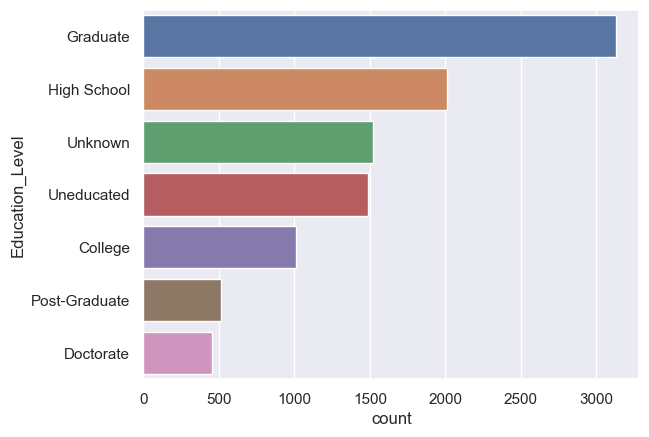

In [11]:
# Bar plot to visualize the education level of the customers
education_df = customer_churn_df['Education_Level'].value_counts().reset_index()
education_df = education_df.rename(columns= {'index': 'Education_Level', 'Education_Level': 'count'})

# Set plot style
sns.set(style="darkgrid")

sns.barplot(x= 'count',
            y = 'Education_Level',
            data= education_df)

# Save figure
plt.savefig('Figures/education_bar.png', bbox_inches='tight')

<AxesSubplot:xlabel='count', ylabel='Income_Category'>

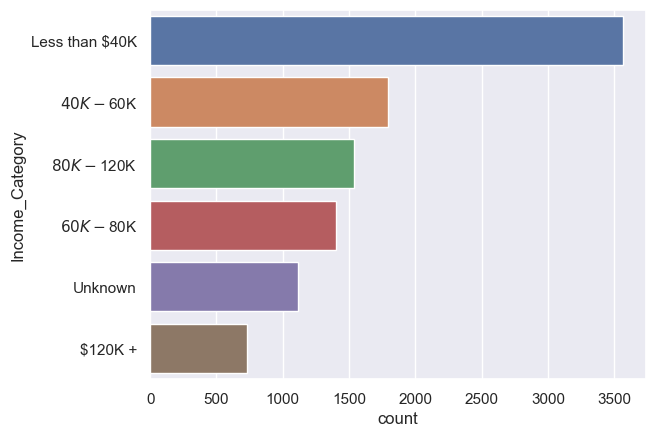

In [12]:
# Bar plot to visualize income of customers
income_df = customer_churn_df['Income_Category'].value_counts().reset_index()
income_df = income_df.rename(columns= {'index': 'Income_Category', 'Income_Category': 'count'})

# Plot style
sns.set(style="darkgrid")

sns.barplot(x= 'count',
            y = 'Income_Category',
            data= income_df)

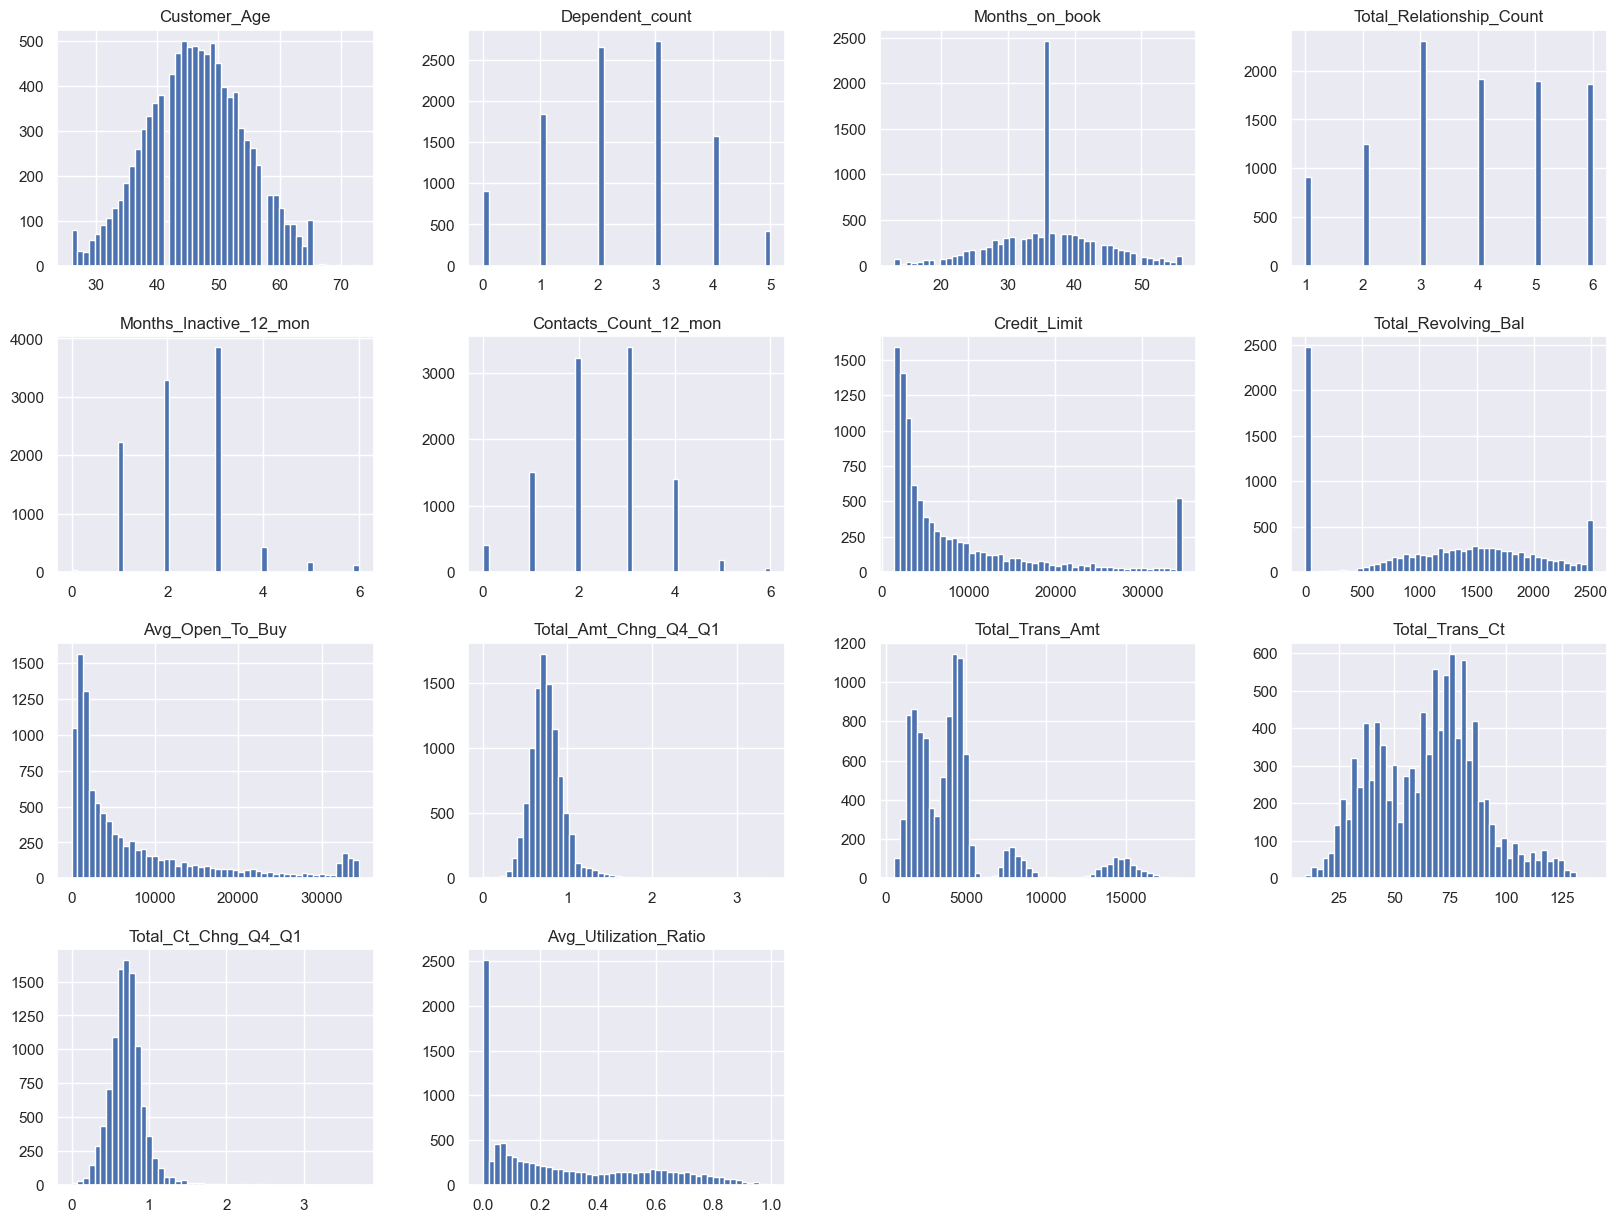

In [13]:
# Plot histograms of numeric columns
fig = customer_churn_df.hist(bins=50, figsize=(20,15))

# Save figure
plt.savefig('Figures/histogram.png')

plt.show()

---
# Data Preprocessing

In [14]:
# Remove outliers using z-score
# Create df with only numeric columns
numeric_cols = customer_churn_df.select_dtypes(include=[np.number]).columns

# Calculate z-score (absolute value)
z_scores = stats.zscore(customer_churn_df[numeric_cols])
abs_z_scores = np.abs(z_scores)

# New df including values with a z-score < 3
filtered_entries = (abs_z_scores < 3).all(axis=1)
customer_churn_df = customer_churn_df[filtered_entries]

# Review filtered df to check difference in row count
print(customer_churn_df.shape)
filtered_df_row_count = customer_churn_df.shape[0]
print(f'{df_row_count - filtered_df_row_count} outliers removed')

(9313, 20)
814 outliers removed


In [15]:
# Replace 'Existing Customer' with 0 and 'Attrited Customer' with 1
customer_churn_df['Attrition_Flag'] = customer_churn_df['Attrition_Flag'].replace({'Existing Customer': 0, 'Attrited Customer': 1})

In [16]:
# Seperate features from the target variable
X = customer_churn_df.drop(columns= ['Attrition_Flag'])
y = customer_churn_df['Attrition_Flag']

In [17]:
# Encode categorical variables
le = LabelEncoder()

categorical_features = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']

for feature in categorical_features:
    X[feature] = le.fit_transform(X[feature])

In [18]:
# Review the features data
X.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
1,58,1,0,6,2,1,0,45,3,1,3,3421.0,2517,904.0,0.992,992,21,0.400,0.736
3,34,0,2,5,2,4,0,24,6,2,2,1438.3,0,1438.3,0.827,3940,82,0.952,0.000
4,49,0,2,5,1,5,0,41,3,5,2,3128.0,749,2379.0,0.598,4369,59,0.735,0.239
5,43,1,4,6,3,0,0,34,5,2,2,33304.0,1833,31471.0,0.428,1448,29,0.381,0.055
7,37,0,2,3,2,4,0,36,4,2,2,5723.0,1873,3850.0,0.851,2732,63,0.853,0.327


In [19]:
# Review the first five encoded entries for the target variable
y[:5]

1    1
3    0
4    0
5    0
7    0
Name: Attrition_Flag, dtype: int64

In [20]:
# Split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Scale features
scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform training and testing data using the scaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


---
# Fitting models and making predictions

In [22]:
# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=500, random_state=78)
rf.fit(X_train, y_train)

# Logistic Regression
lr = LogisticRegression(solver='lbfgs', random_state=1)
lr.fit(X_train_scaled, y_train)


LogisticRegression(random_state=1)

In [23]:
# Predict the test set results
y_pred_knn = knn.predict(X_test_scaled)
y_pred_rf = rf.predict(X_test)
y_pred_lr = lr.predict(X_test_scaled)


---
# KNN analysis

In [24]:
# Classification report for KNN model
print("KNN Classification Report")
print(classification_report(y_test, y_pred_knn))

# Calculating the accuracy score
knn_acc_score = balanced_accuracy_score(y_test, y_pred_knn)
print(f'Accuracy Score: {knn_acc_score}')


KNN Classification Report
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1554
           1       0.78      0.53      0.63       309

    accuracy                           0.90      1863
   macro avg       0.85      0.75      0.79      1863
weighted avg       0.89      0.90      0.89      1863

Accuracy Score: 0.7521897764616211


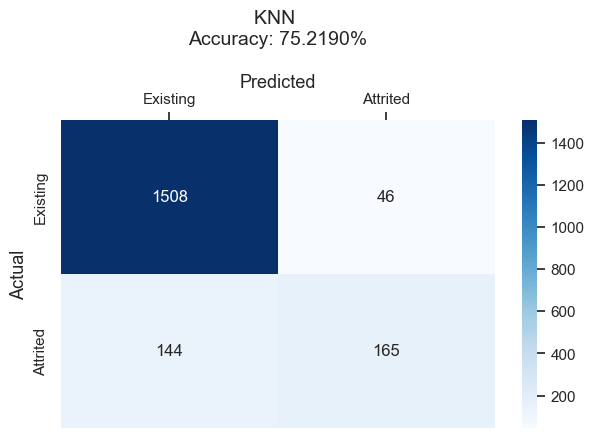

In [25]:
# Create confusion matrix for KNN model
knn_cm = confusion_matrix(y_test, y_pred_knn)

# Confusion matrix vizualization
fig, ax = plt.subplots(figsize= (7, 4))
sns.heatmap(knn_cm, annot=True, fmt='g', 
            cmap='Blues', xticklabels=['Existing', 'Attrited'], yticklabels=['Existing', 'Attrited'])
ax.set_title(f'KNN \nAccuracy: {knn_acc_score:.4%}\n', fontsize= 14)
ax.set_ylabel('Actual', fontsize= 13)
ax.set_xlabel('Predicted', fontsize= 13)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

# Save figure
plt.savefig('Figures/KNN.png', bbox_inches='tight')

---
# Random Forest analysis

In [26]:
# Classification report for random forest
print("Random Classification Report")
print(classification_report(y_test, y_pred_rf))

# Calculate the accuracy score
rf_acc_score = balanced_accuracy_score(y_test, y_pred_rf)
print(f'Accuracy Score: {rf_acc_score}')

Random Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1554
           1       0.95      0.84      0.89       309

    accuracy                           0.97      1863
   macro avg       0.96      0.92      0.94      1863
weighted avg       0.97      0.97      0.97      1863

Accuracy Score: 0.9162074696055278


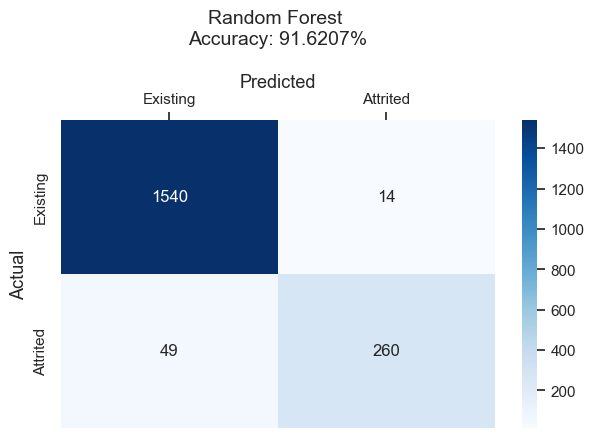

In [27]:
# Create confusion matrix for random forest
rf_cm = confusion_matrix(y_test, y_pred_rf)

# Confusion matrix vizualization
f, ax = plt.subplots(figsize= (7, 4))
sns.heatmap(rf_cm, annot=True, fmt='g', 
            cmap='Blues', xticklabels=['Existing', 'Attrited'], yticklabels=['Existing', 'Attrited'])
ax.set_title(f'Random Forest \nAccuracy: {rf_acc_score:.4%}\n', fontsize= 14)
ax.set_ylabel('Actual', fontsize= 13)
ax.set_xlabel('Predicted', fontsize= 13)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

# Save figure
plt.savefig('Figures/RandomForest.png', bbox_inches='tight')

---
# Logistic Regression analysis

In [28]:
# Classification report for logistic regression model
print("Logistic Regression Classification Report")
print(classification_report(y_test, y_pred_lr))

# Calculate the accuracy score
lr_acc_score = balanced_accuracy_score(y_test, y_pred_lr)
print(f'Accuracy Score: {lr_acc_score}')

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      1554
           1       0.75      0.55      0.63       309

    accuracy                           0.89      1863
   macro avg       0.83      0.76      0.79      1863
weighted avg       0.89      0.89      0.89      1863

Accuracy Score: 0.7564193874873486


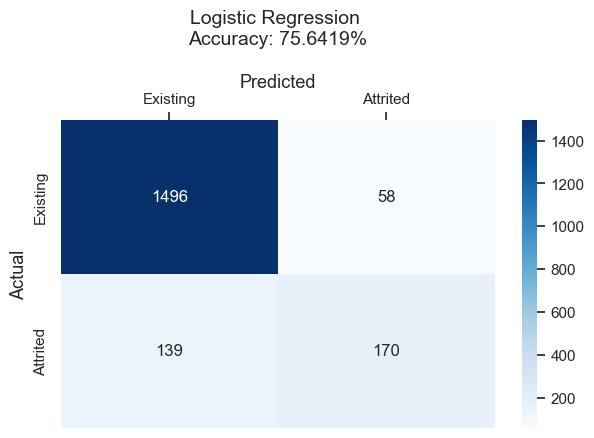

In [29]:
# Create confusion matrix for logistic regression model
lr_cm = confusion_matrix(y_test, y_pred_lr)

# Confusion matrix vizualization
f, ax = plt.subplots(figsize= (7, 4))
sns.heatmap(lr_cm, annot=True, fmt='g', 
            cmap='Blues', xticklabels=['Existing', 'Attrited'], yticklabels=['Existing', 'Attrited'])
ax.set_title(f'Logistic Regression \nAccuracy: {lr_acc_score:.4%}\n', fontsize= 14)
ax.set_ylabel('Actual', fontsize= 13)
ax.set_xlabel('Predicted', fontsize= 13)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

# Save figure
plt.savefig('Figures/LogisticRegression.png', bbox_inches='tight')

---
# Logistic regression model with adjusted weights

In [30]:
# Instatiate logistic regression model
lr_adjusted = LogisticRegression(class_weight='balanced', max_iter=1000)

In [31]:
# Fit the model
lr_adjusted.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [32]:
# Predictions using the scale test data
ypred_lr_adj = lr_adjusted.predict(X_test_scaled)

In [33]:
# Classification report for adjusted logistic regression model
print("Logistic Regression Classification Report")
print(classification_report(y_test, ypred_lr_adj))

# Calculate the accuracy score
lr_adj_acc_score = accuracy_score(y_test, ypred_lr_adj)
print(f'Accuracy Score: {lr_adj_acc_score}')

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      1554
           1       0.52      0.87      0.65       309

    accuracy                           0.84      1863
   macro avg       0.74      0.85      0.77      1863
weighted avg       0.89      0.84      0.86      1863

Accuracy Score: 0.8427267847557702


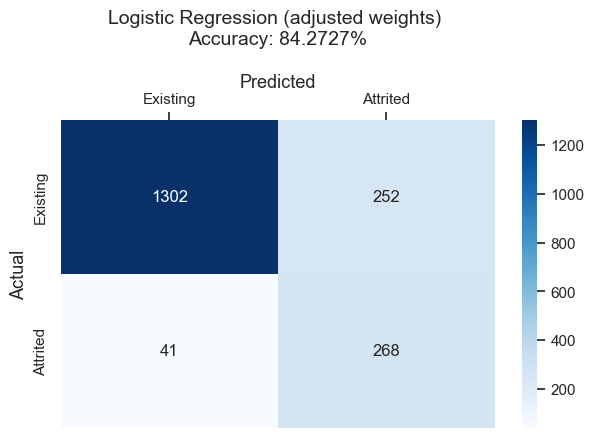

In [34]:
# Create confusion matrix for adjusted weights logistic regression model
lr_adj_cm = confusion_matrix(y_test, ypred_lr_adj)

# Confusion matrix vizualization
f, ax = plt.subplots(figsize= (7, 4))
sns.heatmap(lr_adj_cm, annot=True, fmt='g', 
            cmap='Blues', xticklabels=['Existing', 'Attrited'], yticklabels=['Existing', 'Attrited'])
ax.set_title(f'Logistic Regression (adjusted weights) \nAccuracy: {lr_adj_acc_score:.4%}\n', fontsize= 14)
ax.set_ylabel('Actual', fontsize= 13)
ax.set_xlabel('Predicted', fontsize= 13)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

# Save figure
plt.savefig('Figures/LR_Adj_Weights.png', bbox_inches='tight')

---
## Logistic Regression Model with Resampled Training Data

In [35]:
# Instantiate the random oversampler model
# Assign a random_state parameter of 1 to the model
ros = RandomOverSampler(random_state=1)

# Fit the original training data to the random_oversampler model
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

In [36]:
# Count the distinct values of the resampled labels data
y_train_ros.value_counts()

1    6222
0    6222
Name: Attrition_Flag, dtype: int64

In [37]:
# Instantiate the Logistic Regression model
log_model_resampled = LogisticRegression(solver='lbfgs', max_iter=500, random_state=1)

# Fit the model using the resampled training data
log_model_resampled.fit(X_train_ros, y_train_ros)

# Make a prediction using the testing data
ros_predictions = log_model_resampled.predict(X_test)

In [38]:
# Print the classification report for the model
print("Logistic Regression Resampled Classification Report")
print(classification_report(y_test, ros_predictions))

# Print the balanced_accuracy score of the model 
log_model_resample_acc = accuracy_score(y_test, ros_predictions)
print(f'Accuracy Score: {log_model_resample_acc}')

Logistic Regression Resampled Classification Report
              precision    recall  f1-score   support

           0       0.96      0.82      0.89      1554
           1       0.49      0.85      0.62       309

    accuracy                           0.83      1863
   macro avg       0.73      0.84      0.76      1863
weighted avg       0.89      0.83      0.84      1863

Accuracy Score: 0.8287707997852926


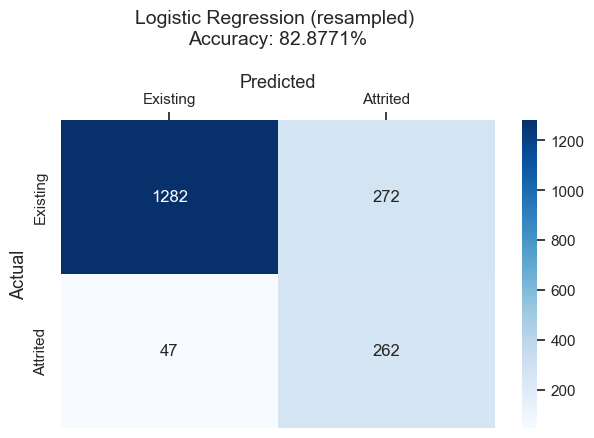

In [39]:
# Generate a confusion matrix for the model
ros_lr_cm = confusion_matrix(y_test, ros_predictions)

# Confusion matrix vizualization
f, ax = plt.subplots(figsize= (7, 4))
sns.heatmap(ros_lr_cm, annot=True, fmt='g', 
            cmap='Blues', xticklabels=['Existing', 'Attrited'], yticklabels=['Existing', 'Attrited'])
ax.set_title(f'Logistic Regression (resampled) \nAccuracy: {log_model_resample_acc:.4%}\n', fontsize= 14)
ax.set_ylabel('Actual', fontsize= 13)
ax.set_xlabel('Predicted', fontsize= 13)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

# Save figure
plt.savefig('Figures/LR_ROS.png', bbox_inches='tight')

---
# Optimize models using feature importance

In [40]:
#Feature importances
importances = rf.feature_importances_

# Sort the features by their importance
ft_imp_arr = sorted(zip(rf.feature_importances_, X.columns), reverse=True)
ft_imp_arr

[(0.20640194651528845, 'Total_Trans_Amt'),
 (0.17119322985567162, 'Total_Trans_Ct'),
 (0.10884790787908374, 'Total_Revolving_Bal'),
 (0.09968714381400937, 'Total_Ct_Chng_Q4_Q1'),
 (0.06627854358512064, 'Total_Relationship_Count'),
 (0.0626707311785822, 'Avg_Utilization_Ratio'),
 (0.059628971939898724, 'Total_Amt_Chng_Q4_Q1'),
 (0.034369109473407156, 'Credit_Limit'),
 (0.03253871403979667, 'Customer_Age'),
 (0.03226063690395316, 'Avg_Open_To_Buy'),
 (0.024713628537590973, 'Months_on_book'),
 (0.024655629078544003, 'Months_Inactive_12_mon'),
 (0.01867607291528816, 'Contacts_Count_12_mon'),
 (0.013706529888164872, 'Dependent_count'),
 (0.012158549493576002, 'Education_Level'),
 (0.0114144213360089, 'Income_Category'),
 (0.009270527304585626, 'Marital_Status'),
 (0.009216881151447493, 'Gender'),
 (0.0023108251099822593, 'Card_Category')]

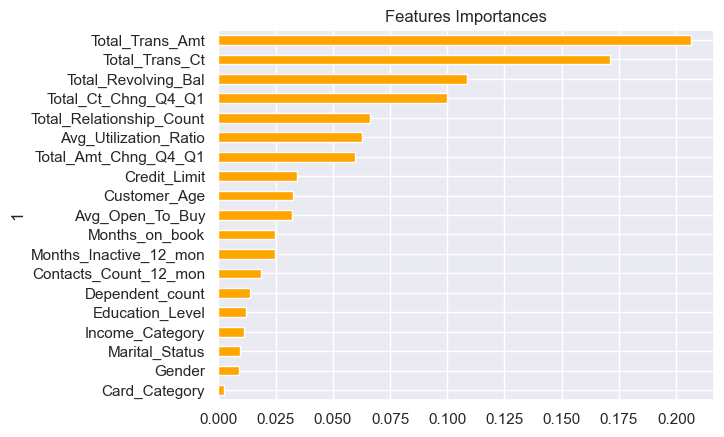

In [41]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='orange', title= 'Features Importances', legend=False)

# Save figure
plt.savefig('Figures/feature_importances.png', bbox_inches='tight')

---
# Retrain models with optimized features

In [42]:
# Create new dataframe to only include the important features
# Create a list with the columns to drop based on feature importance array
columns_to_drop = ft_imp_arr[10:]

# List with only columns names
columns_to_drop = [i[1] for i in columns_to_drop]

# New dataframe using feature importance
churn_df_ftimp = customer_churn_df.drop(columns = columns_to_drop)
churn_df_ftimp

,Attrition_Flag,Customer_Age,Total_Relationship_Count,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
1,1,58,3,3421.0,2517,904.0,0.992,992,21,0.400,0.736
3,0,34,6,1438.3,0,1438.3,0.827,3940,82,0.952,0.000
4,0,49,3,3128.0,749,2379.0,0.598,4369,59,0.735,0.239
5,0,43,5,33304.0,1833,31471.0,0.428,1448,29,0.381,0.055
7,0,37,4,5723.0,1873,3850.0,0.851,2732,63,0.853,0.327
...,...,...,...,...,...,...,...,...,...,...,...
10122,0,50,4,3640.0,659,2981.0,0.938,3756,70,0.842,0.181
10123,1,38,6,12050.0,1821,10229.0,0.630,2381,40,0.481,0.151
10124,1,49,3,2951.0,2437,514.0,0.765,2519,36,0.565,0.826
10125,0,54,4,2872.0,2035,837.0,0.613,1770,47,0.741,0.709


In [43]:
# Seperate features from the target variable
X = churn_df_ftimp.drop(columns= ['Attrition_Flag'])
y = churn_df_ftimp['Attrition_Flag']

In [44]:
# Review the new features data
X.head()

,Customer_Age,Total_Relationship_Count,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
1,58,3,3421.0,2517,904.0,0.992,992,21,0.400,0.736
3,34,6,1438.3,0,1438.3,0.827,3940,82,0.952,0.000
4,49,3,3128.0,749,2379.0,0.598,4369,59,0.735,0.239
5,43,5,33304.0,1833,31471.0,0.428,1448,29,0.381,0.055
7,37,4,5723.0,1873,3850.0,0.851,2732,63,0.853,0.327


In [45]:
# Split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# Scale features
scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform training and testing data using the scaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [47]:
# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=500, random_state=78)
rf.fit(X_train, y_train)

# Logistic Regression
lr = LogisticRegression(solver='lbfgs', random_state=1)
lr.fit(X_train_scaled, y_train)

LogisticRegression(random_state=1)

In [48]:
# Predict the test set results
y_pred_knn = knn.predict(X_test_scaled)
y_pred_rf = rf.predict(X_test)
y_pred_lr = lr.predict(X_test_scaled)

---
# KNN analysis

In [49]:
# Classification report for KNN model
print("KNN Classification Report")
print(classification_report(y_test, y_pred_knn))

# Calculating the accuracy score
knn_acc_score = balanced_accuracy_score(y_test, y_pred_knn)
print(f'Accuracy Score: {knn_acc_score}')


KNN Classification Report
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1554
           1       0.82      0.68      0.74       309

    accuracy                           0.92      1863
   macro avg       0.88      0.82      0.85      1863
weighted avg       0.92      0.92      0.92      1863

Accuracy Score: 0.8246835601204534


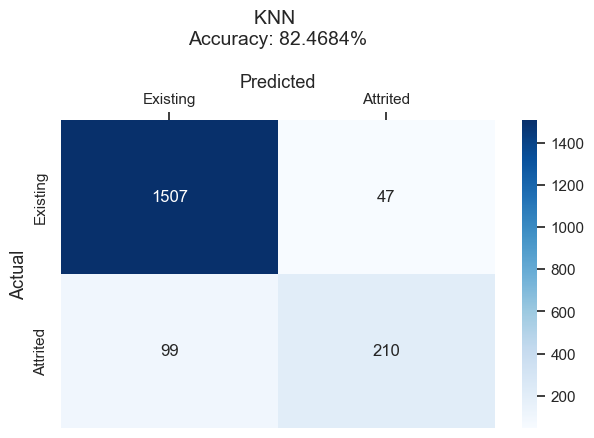

In [50]:
# Create confusion matrix for KNN model
knn_cm = confusion_matrix(y_test, y_pred_knn)

# Confusion matrix vizualization
f, ax = plt.subplots(figsize= (7, 4))
sns.heatmap(knn_cm, annot=True, fmt='g', 
            cmap='Blues', xticklabels=['Existing', 'Attrited'], yticklabels=['Existing', 'Attrited'])
ax.set_title(f'KNN \nAccuracy: {knn_acc_score:.4%}\n', fontsize= 14)
ax.set_ylabel('Actual', fontsize= 13)
ax.set_xlabel('Predicted', fontsize= 13)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

# Save figure
plt.savefig('Figures/KNN_optimized.png', bbox_inches='tight')

---
# Random Forest analysis

In [51]:
# Classification report for random forest
print("Random Classification Report")
print(classification_report(y_test, y_pred_rf))

# Calculate the accuracy score
rf_acc_score = balanced_accuracy_score(y_test, y_pred_rf)
print(f'Balanced accuracy Score: {rf_acc_score}')

Random Classification Report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1554
           1       0.91      0.87      0.89       309

    accuracy                           0.97      1863
   macro avg       0.94      0.93      0.94      1863
weighted avg       0.96      0.97      0.96      1863

Balanced accuracy Score: 0.9285276955179868


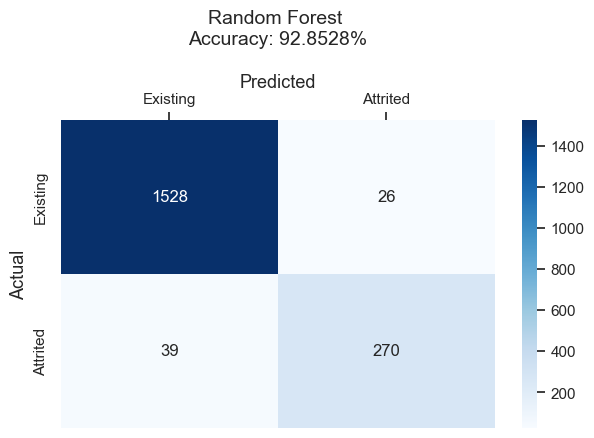

In [52]:
# Create confusion matrix for random forest
rf_cm = confusion_matrix(y_test, y_pred_rf)

# Confusion matrix vizualization
f, ax = plt.subplots(figsize= (7, 4))
sns.heatmap(rf_cm, annot=True, fmt='g', 
            cmap='Blues', xticklabels=['Existing', 'Attrited'], yticklabels=['Existing', 'Attrited'])
ax.set_title(f'Random Forest \nAccuracy: {rf_acc_score:.4%}\n', fontsize= 14)
ax.set_ylabel('Actual', fontsize= 13)
ax.set_xlabel('Predicted', fontsize= 13)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

# Save figure
plt.savefig('Figures/RF_optimized.png', bbox_inches='tight')

---
# Logistic Regression analysis

In [53]:
# Classification report for logistic regression model
print("Logistic Regression Classification Report")
print(classification_report(y_test, y_pred_lr))

# Calculate the accuracy score
lr_acc_score = balanced_accuracy_score(y_test, y_pred_lr)
print(f'Accuracy Score: {lr_acc_score}')

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1554
           1       0.71      0.52      0.60       309

    accuracy                           0.88      1863
   macro avg       0.81      0.74      0.77      1863
weighted avg       0.88      0.88      0.88      1863

Accuracy Score: 0.7376641551398833


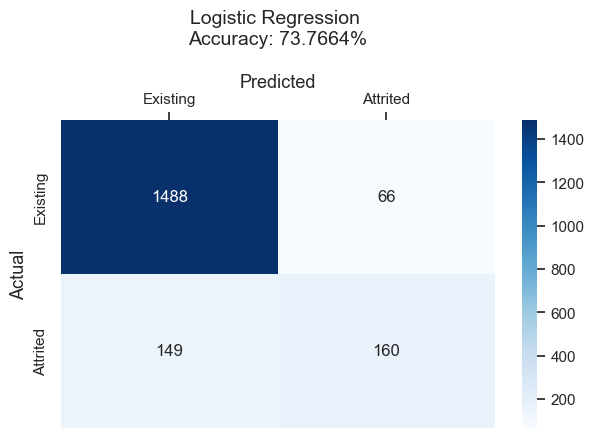

In [54]:
# Create confusion matrix for logistic regression model
lr_cm = confusion_matrix(y_test, y_pred_lr)

# Confusion matrix vizualization
f, ax = plt.subplots(figsize= (7, 4))
sns.heatmap(lr_cm, annot=True, fmt='g', 
            cmap='Blues', xticklabels=['Existing', 'Attrited'], yticklabels=['Existing', 'Attrited'])
ax.set_title(f'Logistic Regression \nAccuracy: {lr_acc_score:.4%}\n', fontsize= 14)
ax.set_ylabel('Actual', fontsize= 13)
ax.set_xlabel('Predicted', fontsize= 13)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

# Save figure
plt.savefig('Figures/LR_optimized.png', bbox_inches='tight')